In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# pip install surprise

In [6]:
# importing dafault libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Surprise library
from surprise import Dataset, KNNWithMeans, accuracy, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import GridSearchCV

In [8]:
# Importing dictionary library
from collections import defaultdict 

In [9]:
# Importing dataset
df = pd.read_csv('Electronic_dataset.csv')

In [10]:
# Replacing the column name = User - uid, Productuts - pid, ratings - ratings
df.columns = ['uid', 'pid', 'ratings', 'timestamp']

In [11]:
# Dropping Timestamp column as we don't need any use for this dataset
df.drop(['timestamp'], axis = 1, inplace = True)

In [12]:
df.head() 

,uid,pid,ratings
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0
2,A1SINU2I4IOPNU,B000GBO9IM,4.0
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0


In [13]:
df.shape

(500000, 3)

In [14]:
df.count()

uid        500000
pid        500000
ratings    500000
dtype: int64

In [15]:
df.columns

Index(['uid', 'pid', 'ratings'], dtype='object')

In [16]:
df.dtypes

uid         object
pid         object
ratings    float64
dtype: object

In [17]:
# Replace '?' with nan value if found
df.ratings.replace('?', np.nan, inplace = True)

In [18]:
# Checking the nan value if any presents in rating column
a = df.ratings.isnull().sum()
if a > 0:
    Print('There is NaN value presented in ratingcolumn.')
else:
    print('There is no NaN value presented in rating column.')

There is no NaN value presented in rating column.


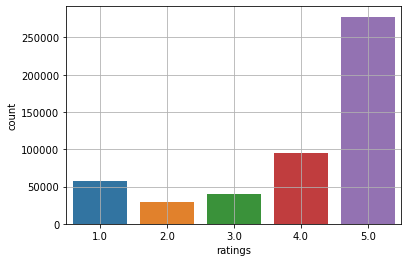

In [19]:
# Plotting the rating column
sns.countplot(df.ratings)
plt.grid()

<AxesSubplot:xlabel='ratings', ylabel='Density'>

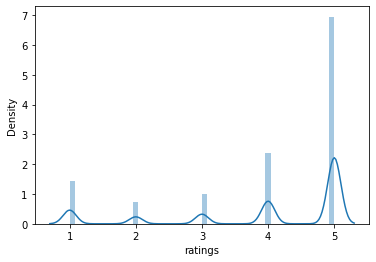

In [20]:
sns.distplot(df.ratings)

From both graphs, most of the users have rated 5.0 and follow rated 4.0. The low rated product is 2.0.

In [21]:
# Getting how many users have rated and stored in the user
user = df['uid'].value_counts().value_counts()

In [22]:
# Making a dataframe
user = pd.DataFrame(user)

In [23]:
user.index.name = 'Total_rating_given_by_User'

Dataframe index is about total products which was rated by users

In [24]:
# uid = users
user.iloc[::-1]

,uid
Total_rating_given_by_User,
36,1
30,1
29,1
28,1
24,1
22,1
21,1
34,1
23,2


As we can see, the top user has rated 36 products, following by 30 and so on so forth. The maximum users have rated only 1 product, which may be a disadvantage for our recommended system.

In [25]:
# Getting the top 10 users who have rated most of the products.
most_rated_user = df.groupby('uid').size().sort_values(ascending = False)[:10]

In [26]:
most_rated_user

uid
A680RUE1FDO8B     36
A3OXHLG6DIBRW8    34
ADLVFFE4VBT8      30
A5JLAU2ARJ0BO     29
A2NOW4U7W3F7RI    28
A231WM2Z2JL0U3    24
A2AY4YUOX2N1BQ    23
A6FIAB28IS79      23
A4WEZJOIZIV4U     22
A1ODOGXEYECQQ8    21
dtype: int64

In [27]:
# Counting total users
counts = df['uid'].value_counts()

### Sparse Dataset

In [28]:
# Putting a threshold to our user column to make sparse
df_final = df[df['uid'].isin(counts[counts >= 6].index)]

In [29]:
# Sparse dataframe
df_final.head()

,uid,pid,ratings
26,A2HX3D3MPPASNS,B004I3VZM2,4.0
214,AZNUHQSHZHSUE,B000FJEYZI,1.0
264,A1YEPFLLH42OU1,B00E3W15P0,5.0
286,A2GYV87WW0DMSN,B0009Y7APU,5.0
413,A10Y058K7B96C6,B005HSG3VK,5.0


In [30]:
df_final.shape

(5912, 3)

Our dataframe is now less dense.

## Popularity

In [31]:
# Total user
df_final.uid.nunique()

724

In [32]:
# Total product
df_final.pid.nunique()

4971

In [33]:
# Getting the mean of product column
book_ratings = pd.DataFrame(df_final.groupby('pid').mean())
book_ratings.head()

,ratings
pid,
1400501466,1.0
1400532655,2.0
9985511476,5.0
B000006OQ8,4.0
B00000DM9M,5.0


In [34]:
# counting the products and stored in the count column
book_ratings['count'] = df_final.groupby('pid').count()['ratings']
book_ratings.head()

,ratings,count
pid,,
1400501466,1.0,1
1400532655,2.0,1
9985511476,5.0,1
B000006OQ8,4.0,1
B00000DM9M,5.0,1


In [35]:
book_ratings.sort_values('ratings', ascending = False).head()

,ratings,count
pid,,
B003WIRFDW,5.0,1
B004HO58SO,5.0,1
B004HVW0ZQ,5.0,1
B004HYG9V4,5.0,1
B004I43MJ0,5.0,1


In [36]:
# Descending order of ratings in the dataset and storing in popular_products
popular_products = book_ratings.sort_values('count', ascending = False)

## Train and Test

In [37]:
# Uploading the dataset again using surprise library and storting in data
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_final, reader)

In [38]:
# Splitting the dataset into 70/30 ratio
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 3)

In [39]:
# Building an anti test for prediction
anti_test = trainset.build_anti_testset()

## Collaborative Filtering

In collaborative filter(CF), we are going to perform these models, 

*   1) SVD
*   2) User - User CF
*   3) Item - Item CF






In [40]:
# SVD model
algo = SVD(random_state = 3)
algo.fit(trainset)
test_svd = algo.test(testset)

In [41]:
accuracy.rmse(test_svd)

RMSE: 1.0494


1.0494217446786032

In [42]:
accuracy.mae(test_svd)

MAE:  0.8143


0.8142785499030049

In [43]:
accuracy.mse(test_svd)

MSE: 1.1013


1.1012859982042835

In [44]:
# Anti test for SVD
anti_test_svd = algo.test(anti_test)

### User - User 

We are using GridsearchCV to find the best parameters.

In [45]:
sim_options = {
                "name": ["msd", "cosine", "pearson_baseline"],
                "user_based": [True], # User - User Collaborative Filtering.
                'k': [10, 20, 30, 40]
              }

In [46]:
param_grid = {"sim_options": sim_options}

In [47]:
gs = GridSearchCV(KNNWithMeans, param_grid, cv = 3)

In [48]:
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [49]:
# Score and best parameters
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.0843483162247958
{'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'k': 10}}


In [50]:
# Score and best parameters
print(gs.best_score["mae"])
print(gs.best_params["mae"])

0.8358343398932169
{'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'k': 10}}


Both results have the same recommended parameters 

In [51]:
# Applying the best parameters to KNNBaseline
user_algo = KNNWithMeans(k = 10, sim_options = {'name' : 'pearson_baseline', 'user_based' : True})

In [52]:
user_algo.fit(trainset)
test_user = user_algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [53]:
accuracy.rmse(test_user)

RMSE: 1.0954


1.095384102148006

In [54]:
accuracy.mae(test_user)

MAE:  0.8447


0.8447471094733169

In [55]:
accuracy.mse(test_user)

MSE: 1.1999


1.199866331238593

In [56]:
# Applying anti test to User - User CF
user_prediction_anti_test = user_algo.test(anti_test)

### Item - Item 

In [57]:
sim_options = {
                "name": ["msd", "cosine", "pearson_baseline"],
                "user_based": [False], # Item - Item Collaborative Filtering
                'k': [10, 20, 30, 40]
              }

In [58]:
param_grid = {"sim_options": sim_options}

In [59]:
gs = GridSearchCV(KNNWithMeans, param_grid, cv = 3)

In [60]:
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [61]:
# Score and best paramters
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.1110601561472342
{'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'k': 10}}


In [62]:
# Score and best paramters
print(gs.best_score["mae"])
print(gs.best_params["mae"])

0.8317987265805731
{'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'k': 10}}


Both results have the same recommended parameters.

In [63]:
# Applying the best parameters to KNNBaseline
item_algo = KNNWithMeans(k = 10, sim_option = {'name' : 'msd', 'user_based' : False})

In [64]:
item_algo.fit(trainset)
test_item = item_algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [65]:
accuracy.rmse(test_item)

RMSE: 1.0956


1.0956303845022246

In [66]:
accuracy.mae(test_item)

MAE:  0.8451


0.8451229080452822

In [67]:
accuracy.mse(test_item)

MSE: 1.2004


1.2004059394444924

In [68]:
# Applying anti test to Item - Item CF
item_prediction_anti_test = item_algo.test(anti_test)

#### Accuracy

In [69]:
# Accuracy score of all the algorithms
s = {'SVD' : [1.0494, 1.1013, 0.8143],
     'User_User' : [1.0954, 1.1999, 0.8447],
     'Item_Item' : [1.0956, 1.2004, 0.8451]}
score = pd.DataFrame(s).T
score.columns = ['RMSE', 'MSE', 'MAE']
score

,RMSE,MSE,MAE
SVD,1.0494,1.1013,0.8143
User_User,1.0954,1.1999,0.8447
Item_Item,1.0956,1.2004,0.8451


## Recommendation

In [70]:
popular_products.head()

,ratings,count
pid,,
B003ES5ZUU,5.000000,13
B007WTAJTO,4.923077,13
B005FYNSPK,4.888889,9
B0088CJT4U,4.333333,9
B00829THK0,4.428571,7


From the dataframe, these products are highly rated and most counted, therefore these are popular products.

In [71]:
# Making a model, which gives five recommendation
def top_5_recommendation(predictions):

    recom = []
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        
        top_5 = []
        top_5.append(uid)
        for i in range(5):
          top_5.append(user_ratings[i][0])
        recom.append(top_5)
        
    recommend = pd.DataFrame(recom, columns = ['uid', 'r1', 'r2', 'r3', 'r4', 'r5'])
    return recommend

In [72]:
# SVD recommendation
top_5_recommendation(anti_test_svd).head()

,uid,r1,r2,r3,r4,r5
0,A18HE80910BTZI,B003ES5ZUU,B00AJG3NK4,B003VAGXWK,B001NJ0D0Y,B00ENZRS76
1,A25PKF8V3Q4IOL,B003ES5ZUU,B007WTAJTO,B0079UAT0A,B006MRAVFE,B003DSCU72
2,A3SOJO7Z7R9WIA,B007WTAJTO,B008AST7R6,B000222YSM,B000V4VIJW,B0030MITDK
3,A3EX8ZFNVDHGPM,B003ES5ZUU,B0034V5RBE,B0010CKE7G,B003TVWNAM,B0091UX3QI
4,AVJ6URCLNJQD2,B003ES5ZUU,B003L18RZU,B009CILPRI,B009NHAEXE,B005CTCD6S


In [73]:
# User - User recommendation
top_5_recommendation(user_prediction_anti_test).head()

,uid,r1,r2,r3,r4,r5
0,A18HE80910BTZI,B00CHH0JF0,B000VEOIDU,B00008VEKA,B003DZJQQI,B00009R7BD
1,A25PKF8V3Q4IOL,B002SQK2F2,B000VEOIDU,B00008VEKA,B003DZJQQI,B00009R7BD
2,A3SOJO7Z7R9WIA,B002SQK2F2,B00CHH0JF0,B00008VEKA,B003DZJQQI,B00009R7BD
3,A3EX8ZFNVDHGPM,B002SQK2F2,B00CHH0JF0,B000VEOIDU,B003DZJQQI,B00009R7BD
4,AVJ6URCLNJQD2,B002SQK2F2,B00CHH0JF0,B000VEOIDU,B00008VEKA,B00009R7BD


In [74]:
# Item - Item recommendation
top_5_recommendation(item_prediction_anti_test).head()

,uid,r1,r2,r3,r4,r5
0,A18HE80910BTZI,B00064C53K,B00015GYU4,B00D2LR76E,B0002A9RFM,B00BFO14W8
1,A25PKF8V3Q4IOL,B00B7MZCUI,B0000DBJTZ,B00007KDVJ,B00DBCJKPK,B006YWCQLO
2,A3SOJO7Z7R9WIA,B002SQK2F2,B00CHH0JF0,B00008VEKA,B003DZJQQI,B00009R7BD
3,A3EX8ZFNVDHGPM,B00FCROWMS,B00E98O7GC,B00JIFMXSK,B00G537M7K,B0011E4N5C
4,AVJ6URCLNJQD2,B002SQK2F2,B00CHH0JF0,B000VEOIDU,B00008VEKA,B00009R7BD


### Conclusion

In this dataset, we have performed many algorithms that gave us many recommendations by using SVD, KNNBaseline. The dataset contains 500000 records of products, users, and ratings, still most of the users have rated only one product, which was slightly disadvantaged for this dataset. For the memory reduction, we have made the dataset sparse, so it works efficiently.
Here, 'RMSE' is used for the measured to this dataset since it's most preferred over the other.
* Popularity recommendations show only the products that are popular in the market. It doesn’t require any personal interest of the user or particular preference. It gives recommendations by the count of rating and how much rated it. In this dataset, the products ‘B003ES5ZUU’ and ‘B007WTAJTO’ are highly rated products and popular among all users. If any user wants a popular product, then these products are well recommended for them.
* SVD is model-based collaborative filtering, where the model predicts the user’s rating who hasn’t rated the product. It is the most useful model in collaborative filtering.
* KNNWithMeans, a memory-based algorithm, which gives the result on User - User and Item - Item collaborative filter if we want prediction on a person’s similar interests or behaviors.

It would be good if users have rated the product over one. Although, we found a recommendation for the user on their choices. When a user wants products by preference, then the popular recommendation algorithm is not preferable at all. Different algorithms gave various recommendations depends on their preference.